<a href="https://colab.research.google.com/github/stilldeserveahappyending/practice25/blob/main/age_predictor_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Производственная

Импорт библиотек

In [2]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00


In [2]:
from PIL import Image
import matplotlib.pyplot as plt


import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from google.colab import drive
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Датасет и эмбендинговая модель

In [ ]:
data_dir = '/content/drive/MyDrive/dataset/UTKFfix/UTKFace'
# Загрузка модели
model = tf.saved_model.load('/content/drive/MyDrive/dataset/faceNet')
infer = model.signatures['serving_default']

Обработка

In [ ]:
def preprocess_image(img_path):
    """Загрузка и предобработка изображения"""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Не удалось загрузить изображение: {img_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (160, 160))
    img = img.astype(np.float32)
    img = (img - 127.5) / 128.0  # Нормализация для FaceNet
    return img

# Списки для данных
embeddings = []
ages = []

Получение эмбендингов

In [ ]:
def get_face_embedding(img_path):
    """Извлечение эмбеддинга лица"""
    img = preprocess_image(img_path)
    if img is None:
        return None

    img_array = np.expand_dims(img, axis=0)
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Получение эмбеддинга
    result = infer(img_tensor)
    embedding = result['Bottleneck_BatchNorm'].numpy()
    return embedding.squeeze(0)
# Обработка изображений
for img_name in os.listdir(data_dir):
    try:
        # Парсинг возраста из имени файла
        parts = img_name.split('_')
        if not parts[0].isdigit():
            continue

        age = int(parts[0])
        img_path = os.path.join(data_dir, img_name)

        # Генерация эмбеддинга
        embedding = get_face_embedding(img_path)
        if embedding is None:
            continue

        # Сохраняем данные
        embeddings.append(embedding)
        ages.append(age)

    except Exception as e:
        print(f"Ошибка обработки {img_name}: {str(e)}")
        continue

Обработка результатов

In [ ]:
# Преобразуем в numpy arrays
embeddings = np.array(embeddings)
ages = np.array(ages)

print("\nСтатистика датасета:")
print(f"Всего образцов: {len(embeddings)}")
print(f"Размерность эмбеддингов: {embeddings.shape}")
print(f"Минимальный возраст: {np.min(ages)}")
print(f"Максимальный возраст: {np.max(ages)}")
print(f"Средний возраст: {np.mean(ages):.1f}")

# Разделение данных без стратификации по группам
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    ages,
    test_size=0.2,
    random_state=42
)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")


Статистика датасета:
Всего образцов: 23539
Размерность эмбеддингов: (23539, 128)
Минимальный возраст: 1
Максимальный возраст: 116
Средний возраст: 33.5

Размер обучающей выборки: 18831
Размер тестовой выборки: 4708


Сохранение выборки

In [ ]:
save_dir = '/content/drive/MyDrive/age_prediction_data'
os.makedirs(save_dir, exist_ok=True)

# Сохраняем данные
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)


Загрузка выборки

In [12]:
load_dir = '/content/drive/MyDrive/age_prediction_data'

# Загрузка данных
X_train = np.load(os.path.join(load_dir, 'X_train.npy'))
X_test = np.load(os.path.join(load_dir, 'X_test.npy'))
y_train = np.load(os.path.join(load_dir, 'y_train.npy'))
y_test = np.load(os.path.join(load_dir, 'y_test.npy'))

Исправление MTCNN

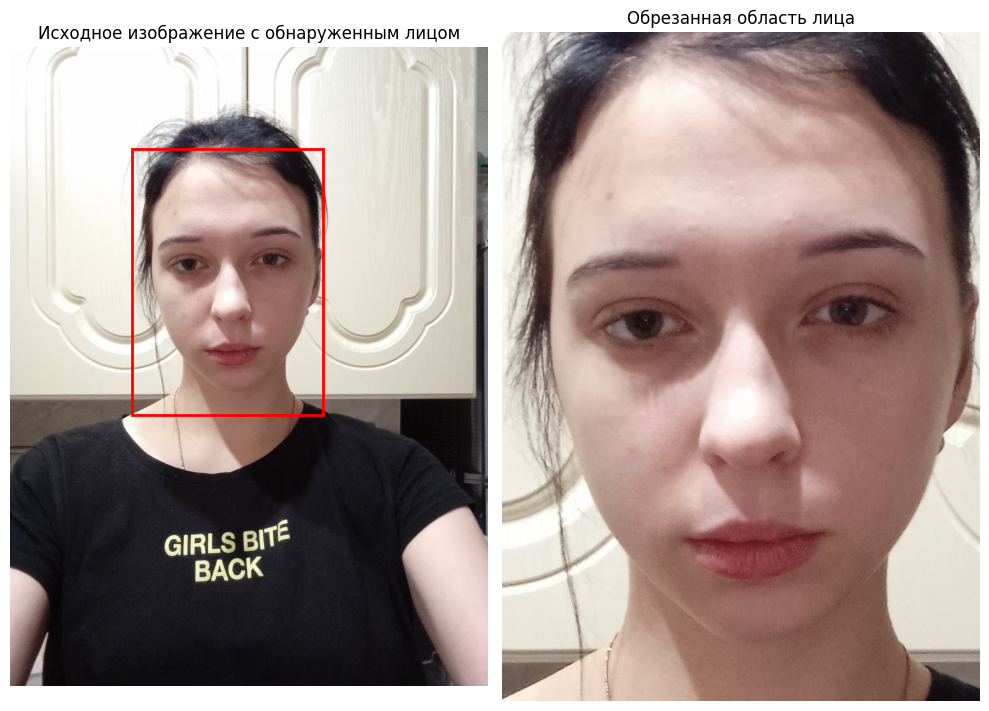

In [4]:
#!pip uninstall -y mtcnn lz4 joblib
#!pip install --upgrade --force-reinstall mtcnn lz4 joblib opencv-python-headless

from mtcnn import MTCNN
import lz4

img = cv2.imread('/content/drive/MyDrive/dataset/train/18-20/0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
face_detector = MTCNN()
detections = face_detector.detect_faces(img)

# Выбираем лицо с наибольшей уверенностью
best_face = max(detections, key=lambda x: x['confidence'])
x, y, w, h = best_face['box']

# Увеличиваем область вокруг лица на 10%
margin = 0.1
x = max(0, int(x - margin * w))
y = max(0, int(y - margin * h))
w = min(img.shape[1] - x, int(w * (1 + 2 * margin)))
h = min(img.shape[0] - y, int(h * (1 + 2 * margin)))

# Обрезаем и возвращаем лицо
face = img[y:y+h, x:x+w]
plt.figure(figsize=(10, 8))

# Рисуем прямоугольник вокруг лица
rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.gca().add_patch(rect)
plt.title('Исходное изображение с обнаруженным лицом')
plt.axis('off')

# 2. Выводим обрезанное лицо
plt.subplot(1, 2, 2)
plt.imshow(face)
plt.title('Обрезанная область лица')
plt.axis('off')

plt.tight_layout()
plt.show()

Модель предсказания возраста по эмбендингам

In [44]:
from mtcnn import MTCNN
import lz4

class AgePredictor:
    def __init__(self, embedding_model_path):
        """Инициализация с загрузкой модели для эмбеддингов"""
        self.embedding_model = tf.saved_model.load(embedding_model_path)
        self.infer = self.embedding_model.signatures['serving_default']
        self.scaler = StandardScaler()
        self.ensemble = None
        self.individual_models = {}
        self.evaluation_metrics = {}
        try:
            self.face_detector = MTCNN()
        except Exception as e:
            return None

    def cutting_face(self, img):
        """Обнаружение и обрезка лица на изображении"""
        # Детекция лиц
        detections = self.face_detector.detect_faces(img)

        if not detections:
            return None

        # Выбираем лицо с наибольшей уверенностью
        best_face = max(detections, key=lambda x: x['confidence'])
        x, y, w, h = best_face['box']

        # Увеличиваем область вокруг лица на 10%
        margin = 0.1
        x = max(0, int(x - margin * w))
        y = max(0, int(y - margin * h))
        w = min(img.shape[1] - x, int(w * (1 + 2 * margin)))
        h = min(img.shape[0] - y, int(h * (1 + 2 * margin)))

        # Обрезаем и возвращаем лицо
        return img[y:y+h, x:x+w]

    def preprocess_image(self, img_path):
        """Загрузка и предобработка изображения"""
        img = cv2.imread(img_path)
        if img is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Ресайз и нормализация
        img = cv2.resize(img, (160, 160))
        img = img.astype(np.float32)
        img = (img - 127.5) / 128.0
        return img

    def preprocess_image_with_cutting(self, img_path):
        """Загрузка и предобработка изображения"""
        img = cv2.imread(img_path)
        if img is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Обнаружение лица
        face = self.cutting_face(img)
        if face is None:
            print("Лицо не обнаружено, используется полное изображение")
            face = img

        # Ресайз и нормализация
        face = cv2.resize(face, (160, 160))
        face = face.astype(np.float32)
        face = (face - 127.5) / 128.0
        return face

    def predict_age_from_image(self, img_path):
        """Предсказание возраста по пути к изображению"""

        # Получение эмбеддинга
        embedding = self.get_face_embedding(img_path)

        # Масштабирование эмбеддинга
        scaled_embedding = self.scaler.transform([embedding])

        # Предсказание возраста
        age = self.ensemble.predict(scaled_embedding)[0]

        # Получение предсказаний отдельных моделей
        individual_preds = {}
        for name, model in self.individual_models.items():
            pred = model.predict(scaled_embedding)[0]
            individual_preds[name] = pred

        return {
            'age': round(age, 1),
            'individual_predictions': individual_preds
        }

    def predict_age_from_image_with_cutting(self, img_path):
        """Предсказание возраста по пути к изображению"""

        # Получение эмбеддинга
        embedding = self.get_face_embedding_with_cutting(img_path)

        # Масштабирование эмбеддинга
        scaled_embedding = self.scaler.transform([embedding])

        # Предсказание возраста
        age = self.ensemble.predict(scaled_embedding)[0]

        # Получение предсказаний отдельных моделей
        individual_preds = {}
        for name, model in self.individual_models.items():
            pred = model.predict(scaled_embedding)[0]
            individual_preds[name] = pred

        return {
            'age': round(age, 1),
            'individual_predictions': individual_preds
        }

    def get_face_embedding(self, img_path):
        """Извлечение эмбеддинга лица"""
        img = self.preprocess_image(img_path)
        if img is None:
            return None

        img_array = np.expand_dims(img, axis=0)
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

        result = self.infer(img_tensor)
        embedding = result['Bottleneck_BatchNorm'].numpy()
        return embedding.squeeze(0)

    def get_face_embedding_with_cutting(self, img_path):
        """Извлечение эмбеддинга лица"""
        img = self.preprocess_image_with_cutting(img_path)
        if img is None:
            return None

        img_array = np.expand_dims(img, axis=0)
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

        result = self.infer(img_tensor)
        embedding = result['Bottleneck_BatchNorm'].numpy()
        return embedding.squeeze(0)

    def train_models(self, X, y):
        """Обучение моделей"""
        # Масштабирование данных
        X_scaled = self.scaler.fit_transform(X)

        # 1. SVM с RBF ядром
        print("Обучение SVM-RBF модели...")
        svm_rbf = SVR(kernel='rbf', gamma='auto', epsilon=0.05, C=100)
        svm_rbf.fit(X_scaled, y)
        self.individual_models['svm_rbf'] = svm_rbf

        # 2. SVM с полиномиальным ядром
        print("Обучение SVM-Poly модели...")
        svm_poly = SVR(kernel='poly', epsilon=0.1, degree=2, coef0=0.5, C=100)
        svm_poly.fit(X_scaled, y)
        self.individual_models['svm_poly'] = svm_poly

        # 3. XGBoost модель
        print("Обучение XGBoost модели...")
        xgb = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        xgb.fit(X_scaled, y)
        self.individual_models['xgboost'] = xgb

        # Создаем ансамбль
        self.ensemble = VotingRegressor(
            estimators=[
                ('svm_rbf', svm_rbf),
                ('svm_poly', svm_poly),
                ('xgboost', xgb)
            ],
            weights=[2, 1, 1]  # Больший вес для SVM(RBF)
        )
        self.ensemble.fit(X_scaled, y)

        print("Обучение моделей завершено!")
        return self

    def evaluate_model(self, X_test, y_test):
        """Оценка модели на тестовых данных"""
        if self.ensemble is None:
            print("Модель не обучена!")
            return None

        X_test_scaled = self.scaler.transform(X_test)
        y_pred = self.ensemble.predict(X_test_scaled)

        # Вычисление метрик
        metrics = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred),
            'MAPE': np.mean(np.abs((y_test - y_pred) / np.maximum(1, y_test))) * 100
        }

        # Оценка отдельных моделей
        individual_metrics = {}
        for name, model in self.individual_models.items():
            y_pred_ind = model.predict(X_test_scaled)
            individual_metrics[name] = {
                'MAE': mean_absolute_error(y_test, y_pred_ind),
                'R2': r2_score(y_test, y_pred_ind)
            }

        self.evaluation_metrics = {
            'ensemble': metrics,
            'individual_models': individual_metrics
        }

        return self.evaluation_metrics

    def print_metrics(self):
        """Вывод метрик оценки"""
        if not self.evaluation_metrics:
            return

        print("\n=== Метрики оценки модели ===")
        for metric, value in self.evaluation_metrics['ensemble'].items():
            if metric == 'MAPE':
                print(f"{metric}: {value:.2f}%")
            else:
                print(f"{metric}: {value:.4f}")

        print("\n=== Метрики отдельных методов ===")
        for model_name, metrics in self.evaluation_metrics['individual_models'].items():
            print(f"\n{model_name}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.4f}")

    def save_models(self, path):
        """Сохранение моделей с обработкой сжатия"""
        if self.ensemble is None:
            return


        joblib.dump({
            'ensemble': self.ensemble,
            'individual_models': self.individual_models,
            'scaler': self.scaler
        }, path, compress=('gzip', 3))
        print(f"Модель сохранена в {path}")

    @classmethod
    def load_models(cls, embedding_model_path, predictor_path):
        """Загрузка моделей"""
        predictor = cls(embedding_model_path)
        models = joblib.load(predictor_path)
        predictor.ensemble = models['ensemble']
        predictor.individual_models = models['individual_models']
        predictor.scaler = models['scaler']
        print("Модели успешно загружены!")
        return predictor

Результат

In [19]:
# Основной блок выполнения
if __name__ == "__main__":
    # Инициализация
    predictor = AgePredictor('/content/drive/MyDrive/dataset/faceNet')
    predictor.train_models(X_train, y_train)

    # Оценка модели
    print("\nОценка модели на тестовых данных...")
    metrics = predictor.evaluate_model(X_test, y_test)
    predictor.print_metrics()

    model_dir = '/content/drive/MyDrive/age_detection_models'
    os.makedirs(model_dir, exist_ok=True)

    predictor_path = os.path.join(model_dir, 'SVM_age_predictor_plus_XGB_plus_MTCNN.pkl')
    predictor.save_models(predictor_path)


Тестирование на изображении: /content/drive/MyDrive/dataset/train/31-40/17.jpg

Предсказанный возраст: 35.9 лет
Индивидуальные предсказания:
  svm_rbf: 37.7 лет
  svm_poly: 35.5 лет
  xgboost: 32.8 лет


Загрузка модели (без MTCNN)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-7-4054115674.py", line 5, in <cell line: 0>
    embedding_model = tf.saved_model.load(faceNet_path)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/load.py", line 912, in load
    result = load_partial(export_dir, None, tags, options)["root"]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/load.py", line 1042, in load_partial
    loader = Loader(object_graph_proto, saved_model_proto, export_dir,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/load.py", line 161, in __init__
    function_deserializ

Загрузка модели (с добавлением MTCNN)

In [45]:
model_path = '/content/drive/MyDrive/age_detection_models/SVM_age_predictor_plus_XGB_plus_MTCNN.pkl'
faceNet_path = '/content/drive/MyDrive/dataset/faceNet'
predictor = AgePredictor.load_models(
    embedding_model_path=faceNet_path,
    predictor_path=model_path
)


Модели успешно загружены!


Использование


Тестирование на изображении: /content/drive/MyDrive/dataset/train/31-40/2.jpg

Предсказанный возраст: 42.1 лет
Индивидуальные предсказания:
  svm_rbf: 43.6 лет
  svm_poly: 41.0 лет
  xgboost: 40.2 лет

Предсказанный возраст: 25.2 лет
Индивидуальные предсказания:
  svm_rbf: 22.9 лет
  svm_poly: 26.6 лет
  xgboost: 28.4 лет


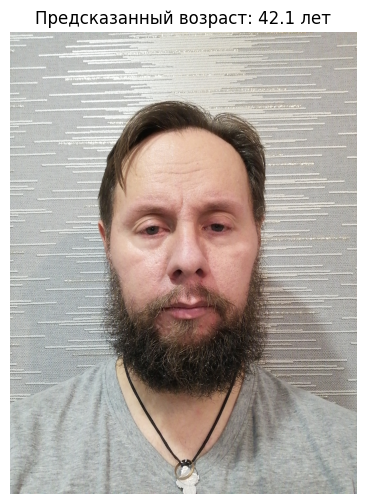

In [47]:
if __name__ == "__main__":
    # Тестирование на новом изображении
    test_img = '/content/drive/MyDrive/dataset/train/31-40/2.jpg'
    print(f"\nТестирование на изображении: {test_img}")
    result = predictor.predict_age_from_image_with_cutting(test_img)
    result2 = predictor.predict_age_from_image(test_img)
    if result:
        print(f"\nПредсказанный возраст: {result['age']} лет")
        print("Индивидуальные предсказания:")
        for model_name, age in result['individual_predictions'].items():
            print(f"  {model_name}: {age:.1f} лет")

    if result2:
        print(f"\nПредсказанный возраст: {result2['age']} лет")
        print("Индивидуальные предсказания:")
        for model_name, age in result2['individual_predictions'].items():
            print(f"  {model_name}: {age:.1f} лет")
        import matplotlib.pyplot as plt

        img = cv2.imread(test_img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.title(f"Предсказанный возраст: {result['age']} лет")
        plt.axis('off')
        plt.show()